### Batch Generator for Object Detection Raccoon Detection with Tensorflow Dataset

In [1]:
import os

import albumentations as A
import cv2
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

#### Load image and annotation path

In [2]:
dataset_path = "C:/Users/BOM5CA/Documents/Palestras_e_Cursos/Treinamento AI Aplicada ICo/DL/Material/dataset/obj_detection"
images_path = os.path.join(dataset_path, "images")
annotation_trn = os.path.join(dataset_path, "train_labels.csv")
annotation_tst = os.path.join(dataset_path, "test_labels.csv")
batch_size = 8
%matplotlib inline

#### Set up Batch Generator

In [3]:
class BatchGenerator:

    def __init__(self, images_path, annotations_path, input_shape, batch_size=16, shuffle=True, jitter=True,
                ):
        self._images_path = images_path
        self._annotations_path = annotations_path

        self._input_shape = input_shape

        self._batch_size = batch_size
        self._shuffle = shuffle
        self._jitter = jitter

        self._images = []
        self._labels = {}
        self._samples_per_label = {}

        skip_header = True

        with open(self._annotations_path, "r") as af:
            for line in af:
                if skip_header:
                    skip_header = False
                    continue
                filename, width, height, label, xmin, ymin, xmax, ymax = line.strip().split(",")

                image = {
                    "filename": os.path.join(self._images_path, filename),
                    "label": label,
                    "bbox": [int(xmin), int(ymin), int(xmax), int(ymax)],
                    "shape": (int(width), int(height))
                }

                # Contar imagens por label
                if label not in self._samples_per_label:
                    self._samples_per_label[label] = 1
                else:
                    self._samples_per_label[label] += 1

                # Id em labels categoricos
                if label not in self._labels:
                    self._labels[label] = len(self._labels)

                self._images.append(image)

            print(f"Foram encontradas {len(self._labels)} classes")
            for lbl, id in self._labels.items():
                print(f'Classe {lbl}({id}) com {self._samples_per_label[lbl]} imagens')

        self._use_imgaug = True
        if self._use_imgaug:
            sometimes = lambda aug: iaa.Sometimes(0.5, aug)

            self._aug_pipe = iaa.Sequential(
                [
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    sometimes(iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        rotate=(-5, 5),
                        shear=(-5, 5),
                    )),
                    iaa.SomeOf((0, 5),
                               [
                                   iaa.OneOf([
                                       iaa.GaussianBlur((0, 3.0)),
                                       iaa.AverageBlur(k=(2, 7)),
                                       iaa.MedianBlur(k=(3, 11)),
                                   ]),
                                   iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
                                   iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
                                   iaa.Add((-10, 10), per_channel=0.5),
                               ],
                               random_order=True
                               )
                ],
                random_order=True
            )
        else:
            prob = 1
            prob2 = 1
            self._aug_pipe = A.Compose([
                A.HorizontalFlip(p=prob2),
                A.GaussNoise(var_limit=[5, 20], p=prob2),
                A.RandomBrightnessContrast(p=prob2),
                A.OneOf([
                    A.GaussianBlur(blur_limit=(1, 3)),
                    A.Blur(blur_limit=(2, 7)),
                    A.MedianBlur(blur_limit=(3, 11))
                ]),
                A.IAASharpen(alpha=(0, 1.0), lightness=(0.75, 1.5), p=prob2),
                A.IAAAdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
                A.ShiftScaleRotate(shift_limit=0.0625,
                                   scale_limit=0.2,
                                   rotate_limit=(-15, 15),
                                   p=prob2),
            ], p=prob)

        self._tf_data = None

    def __len__(self):
        ## retorna o número de batches
        return int(np.ceil(len(self._images) / self._batch_size))

    # Neste BatchGenerator Iremos implementar o iterador
    # Sobrecarregando os métodos built-in iter e next.
    def __iter__(self):
        return self.__next__()

    def __next__(self):
        it = iter(self.tf_data)
        for _ in range(len(self)):
            yield next(it)

    def num_classes(self):
        return len(self._labels)

    def size(self):
        return len(self._images)

    def _norm(self, img):
        return img / 255

    def _process_path(self, image_name):
        image = tf.io.read_file(image_name)
        image = tf.image.decode_jpeg(image, channels=3)

        width, height = self._input_shape
        image = tf.image.resize(image, [height, width])

        label = self._get_label(image_name)

        if self._jitter:
            img, label = self._tf_aug_image(image, label)
            img, label = self._set_shape(img, label)

        image = self._norm(tf.cast(image, tf.float32))

        return image, label

    def _set_shape(self, img, label):
        width, height = self._input_shape
        img.set_shape((height, width, 3))
        label.set_shape(())
        return img, label

    def _get_label(self, file_path):
        # convert the path to a list of path components
        parts = tf.strings.split(file_path, os.path.sep)        
        # The second to last is the class-directory
        one_hot = parts[-2] == np.array(list(self._labels.keys()))
        # Integer encode the label
        return tf.argmax(one_hot)

    def _aug_image(self, img, label):
        img = img.astype(np.uint8)

        if self._use_imgaug:
            img = self._aug_pipe.augment_image(img)
        else:
            try:
                transformed = self._aug_pipe(image=img)
            except ValueError:
                return img
            img = transformed['image']

        return img, label

    def _tf_aug_image(self, img, label):
        y = tf.numpy_function(self._aug_image, [img, label], (tf.uint8, tf.int64))
        return y

    @property
    def labels(self):
        return self._labels

    @property
    def samples_per_label(self):
        return self._samples_per_label

    @property
    def jitter(self):
        return self._jitter

    @property
    def shuffle(self):
        return self._shuffle

    @property
    def tf_data(self):
        if self._tf_data is None:
            self._tf_data = tf.data.Dataset.from_tensor_slices([image['filename'] for image in self._images])
            if self._shuffle:
                self._tf_data = self._tf_data.shuffle(len(self._images), reshuffle_each_iteration=True)
            self._tf_data = self._tf_data.map(self._process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            self._tf_data = self._tf_data.batch(self._batch_size)
            self._tf_data = self._tf_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
            self._tf_data = self._tf_data.repeat(-1)
        return self._tf_data

#### Visualização de imagens

In [4]:
def view_samples(generator):
    iter_generator = iter(generator)
    images = next(iter_generator)
    for img in images[0]:
        plt.imshow(img)
        plt.show()

#### Definir gerados para ambos os datasets treino/teste


In [5]:
train_generator = BatchGenerator(images_path,
                                 annotation_trn,
                                 input_shape=(112, 112),
                                 batch_size=8,
                                 shuffle=True,
                                 jitter=True)

test_generator = BatchGenerator(images_path,
                                annotation_tst,
                                input_shape=(112, 112),
                                batch_size=8,
                                shuffle=False,
                                jitter=False)

Foram encontradas 1 classes
Classe raccoon(0) com 173 imagens
Foram encontradas 1 classes
Classe raccoon(0) com 44 imagens


Visualizar imagens


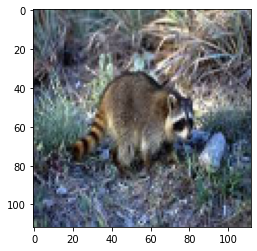

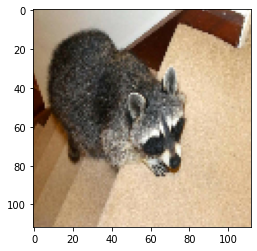

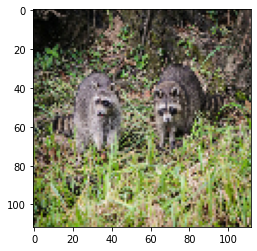

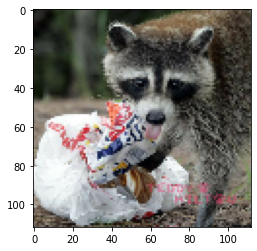

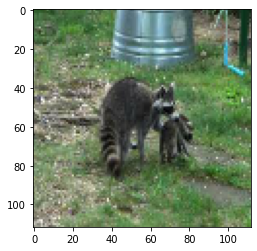

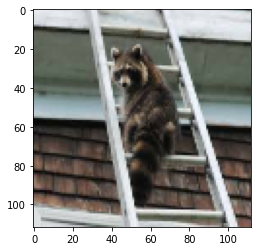

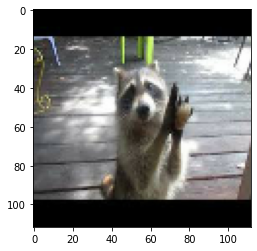

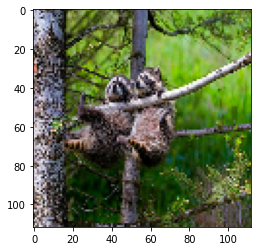

In [6]:
view_samples(train_generator)

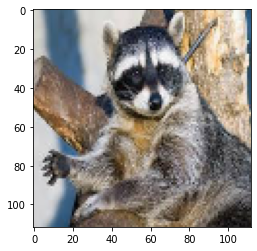

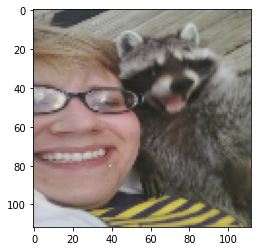

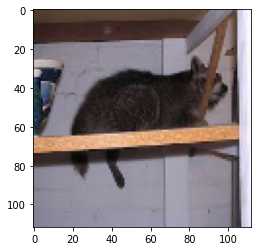

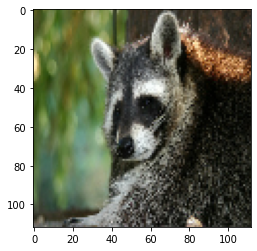

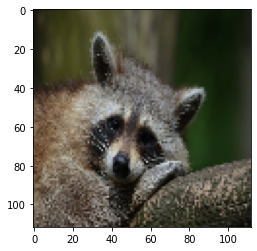

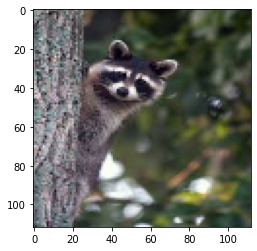

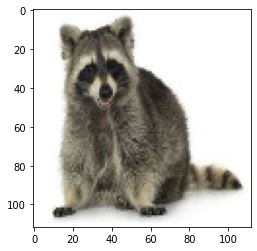

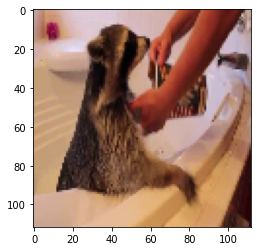

In [18]:
view_samples(test_generator)

In [7]:
import time

def benchmark(generator, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        generator = iter(generator)
        for batch in generator:
            # Performing a training step
            time.sleep(0.01)
    print("Execution time:", time.perf_counter() - start_time)

In [8]:
benchmark(train_generator)

Execution time: 0.6380697999999256
